In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import torch.nn as nn
import os
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
arch = 'resnet50'
model_file = f'{arch}_places365.pth.tar'
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

In [0]:
model.eval()
for param in model.parameters():
    param.requires_grad = False
'convert model to evaluation mode with no grad'

'convert model to evaluation mode with no grad'

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
feature_extractors = []
for i in range(2,6):
  feature_extractors.append(nn.Sequential(*list(model.children())[:-i], nn.AdaptiveAvgPool2d(1)).eval().to(device))

In [0]:
!cp drive/'My Drive'/'Colab Notebooks'/'Automate local TCAV'/'final notebooks'/resized_imgs.pkl  /content/
!cp drive/'My Drive'/'Colab Notebooks'/'Automate local TCAV'/'final notebooks'/masks.pkl  /content/
!cp drive/'My Drive'/'Colab Notebooks'/'Automate local TCAV'/'final notebooks'/classes.pkl  /content/

In [0]:
import pickle
with open('masks.pkl', 'rb') as f:
  masks = pickle.load(f)
with open('resized_imgs.pkl', 'rb') as f:
  imgs = pickle.load(f)
with open('classes.pkl', 'rb') as f:
  labels = np.array(pickle.load(f))

In [0]:
def get_segments(img, mask, threshold = 0.05):
  segs = np.unique(mask)
  segments = []
  total = mask.shape[0]*mask.shape[1]
  for seg in segs:
    idxs = mask==seg
    sz = np.sum(idxs)
    if sz < threshold*total:
      continue
    segment = img*idxs[..., None]
    w, h, _ = np.nonzero(segment)
    segment = segment[np.min(w):np.max(w),np.min(h):np.max(h),:]
    segments.append(segment)
  return segments

In [0]:
img_segments = []
for img, msk in zip(imgs, masks):
  img_segments.append(get_segments(np.array(img), msk, threshold = 0.005))

In [0]:
del masks

In [0]:
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        # trn.Normalize([0, 0, 0], [255, 255, 225]),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [0]:
final_vectors = []
for feature_extractor in feature_extractors:
  all_vectors = []
  for img_seg in img_segments:
      vectors = []
      for seg in img_seg:
        img = Image.fromarray(seg, 'RGB')
        input_img = V(centre_crop(img).unsqueeze(0))
        input_img = input_img.to(device)
        feature_tensor = feature_extractor.forward(input_img)
        del input_img
        feat_vec = feature_tensor.cpu().numpy().squeeze()
        del feature_tensor
        vectors.append(feat_vec)
        all_vectors.append(feat_vec)
  final_vectors.append(all_vectors)

In [0]:
del img_segments

In [0]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [0]:
final_scores = []
for all_vectors in final_vectors:
  X = np.array(all_vectors)
  num_segs = X.shape[0]
  k = int(num_segs**0.5)
  kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
  clusters_labels = kmeans.labels_
  count_threshold = int((num_segs/k)*0.4)
  cluster_names, cluster_counts = np.unique(clusters_labels, return_counts=1)
  good_clusters = cluster_names[cluster_counts>count_threshold]
  print(f'count threshold is {count_threshold}')
  print(f'total number of clusters {len(cluster_names)}')
  print(f'total number of good clusters {len(good_clusters)}')
  linear_models = {}
  model_score = {}
  for cluster in good_clusters:
    positive_instances = np.argwhere(clusters_labels==cluster).squeeze()
    negative_instances = np.argwhere(clusters_labels!=cluster).squeeze()
    num_samples = min(len(positive_instances), len(negative_instances))
    selected_pos = np.random.choice(positive_instances, num_samples, replace=False)
    selected_neg = np.random.choice(negative_instances, num_samples, replace=False)
    train_x = np.append(X[selected_pos], X[selected_neg], axis=0)
    train_y = np.array([1] * num_samples + [0] * num_samples)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y)
    n_components = min(256, len(train_x))
    pca_model = PCA(n_components=n_components)
    lr_model = LogisticRegression()
    pca_lr_model = Pipeline(steps = [('pca', pca_model), ('lr', lr_model)])
    # pca_lr_model.set_params(pca__n_components=256, lr__penalty='l2')
    pca_lr_model.fit(train_x, train_y)
    linear_models[cluster] = pca_lr_model
    model_score[cluster] = pca_lr_model.score(val_x, val_y)
  final_scores.append(model_score)

count threshold is 43
total number of clusters 108
total number of good clusters 104
count threshold is 43
total number of clusters 108
total number of good clusters 92
count threshold is 43
total number of clusters 108
total number of good clusters 97
count threshold is 43
total number of clusters 108
total number of good clusters 95


In [0]:
mean_accs = []
for sc in final_scores:
  mean_accs.append(np.mean(list(sc.values())))
layers = ['conv_5','conv_4','conv_3','conv_2']

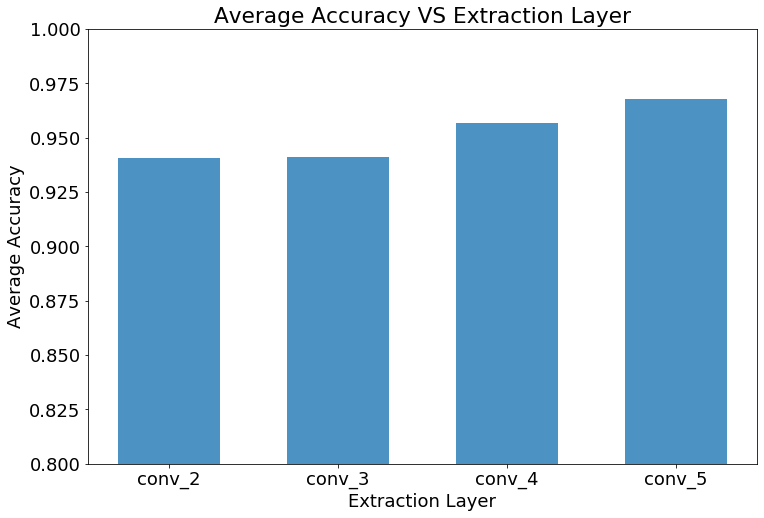

In [0]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 18})
plt.bar(layers[::-1], mean_accs[::-1], alpha=0.8, width=0.6)
plt.ylim([0.8,1])
plt.xlabel('Extraction Layer')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy VS Extraction Layer')
plt.show()

In [0]:
mean_accs[::-1]

[0.940469477785402, 0.9411085043596118, 0.9566187473329968, 0.9679362781641715]